In [1]:
#Create the context manager class
import sqlite3
class SQLServer:
    def __init__(self, server):
        self.server = server
    def __enter__(self):
        self.conn =sqlite3.connect(self.server)
        self.cur = self.conn.cursor()
        return self
          
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.conn.close()

# Task 2
# 1. Create four tables, load data to all tables using "pension_2014.csv".

In [4]:
geo='''CREATE TABLE IF NOT EXISTS geotb ( geoid text PRIMARY KEY, geoname text NOT NULL);'''

govtype='''CREATE TABLE IF NOT EXISTS govtypetb ( govtypeid integer PRIMARY KEY, 
govtypelabel text NOT NULL);'''

penitem='''CREATE TABLE IF NOT EXISTS penitemtb ( penitemid integer PRIMARY KEY, 
penitemlabel text NOT NULL);'''

penvalue='''CREATE TABLE IF NOT EXISTS penvaluetb ( geoid text NOT NULL, 
govtypeid integer NOT NULL,penitemid integer NOT NULL, amount integer NOT NULL, 
PRIMARY KEY (geoid, govtypeid, penitemid));'''

with SQLServer('pension2014') as sqls:
    sqls.cur.execute(geo)
    sqls.cur.execute(govtype)
    sqls.cur.execute(penitem)
    sqls.cur.execute(penvalue)

# 2. Load data from pension_2014.csv to tables


In [9]:
import pandas as pd
data=pd.read_csv('pension_2014.csv')
geotb=data[['GEO.id','GEO.display-label']]
geotb=geotb.drop_duplicates('GEO.id')


In [10]:

insert_query='''INSERT INTO geotb (geoid, geoname) VALUES(?, ?)'''
with SQLServer('pension2014') as sqls:
    sqls.cur.executemany(insert_query,geotb.values.tolist())
    sqls.conn.commit()

govtypetb=data[['GOVTYPE.id','GOVTYPE.display-label']]
govtypetb=govtypetb.drop_duplicates('GOVTYPE.id')



In [12]:
insert_query='''INSERT INTO govtypetb (govtypeid, govtypelabel) VALUES(?, ?)'''
with SQLServer('pension2014') as sqls:
    sqls.cur.executemany(insert_query,govtypetb.values.tolist())
    sqls.conn.commit()

penitemtb=data[['PENITEM.id','PENITEM.display-label']]
penitemtb=penitemtb.drop_duplicates('PENITEM.id')



In [13]:
insert_query='''INSERT INTO penitemtb (penitemid, penitemlabel) VALUES(?, ?)'''
with SQLServer('pension2014') as sqls:
    sqls.cur.executemany(insert_query,penitemtb.values.tolist())
    sqls.conn.commit()

penvaluetb=data[['GEO.id','GOVTYPE.id','PENITEM.id','AMOUNT']]
penvaluetb=penvaluetb.drop_duplicates(['GEO.id','GOVTYPE.id','PENITEM.id'])
penvaluetb=penvaluetb[penvaluetb['AMOUNT']!='N']
penvaluetb=penvaluetb[penvaluetb['AMOUNT']!='X']
penvaluetb['AMOUNT']=pd.to_numeric(penvaluetb['AMOUNT'])



In [14]:
insert_query='''INSERT INTO penvaluetb (geoid, govtypeid, penitemid, amount) VALUES(?, ?, ?, ?)'''
with SQLServer('pension2014') as sqls:
    sqls.cur.executemany(insert_query,penvaluetb.values.tolist())
    sqls.conn.commit()

In [15]:

#creating new table with same columns as pension_2014.csv
query_pension='''CREATE TABLE IF NOT EXISTS pension_2014 ( geoid text NOT NULL, geoname text NOT NULL 
,govtypeid integer NOT NULL, govtypelabel text NOT NULL,penitemid integer NOT NULL, 
penitemlabel text NOT NULL, amount integer NOT NULL, PRIMARY KEY (geoid, govtypeid, penitemid));'''

with SQLServer('pension2014') as sqls:
    sqls.cur.execute(query_pension)

join_query= '''INSERT INTO pension_2014 SELECT geotb.geoid,geotb.geoname,govtypetb.govtypeid,
govtypetb.govtypelabel,penitemtb.penitemid,penitemtb.penitemlabel,
penvaluetb.amount FROM penvaluetb
INNER JOIN geotb ON penvaluetb.geoid=geotb.geoid INNER JOIN govtypetb ON 
penvaluetb.govtypeid=govtypetb.govtypeid 
INNER JOIN penitemtb ON penvaluetb.penitemid=penitemtb.penitemid;'''

with SQLServer('pension2014') as sqls:
    sqls.cur.execute(join_query)
    sqls.conn.commit()

# Task 3 

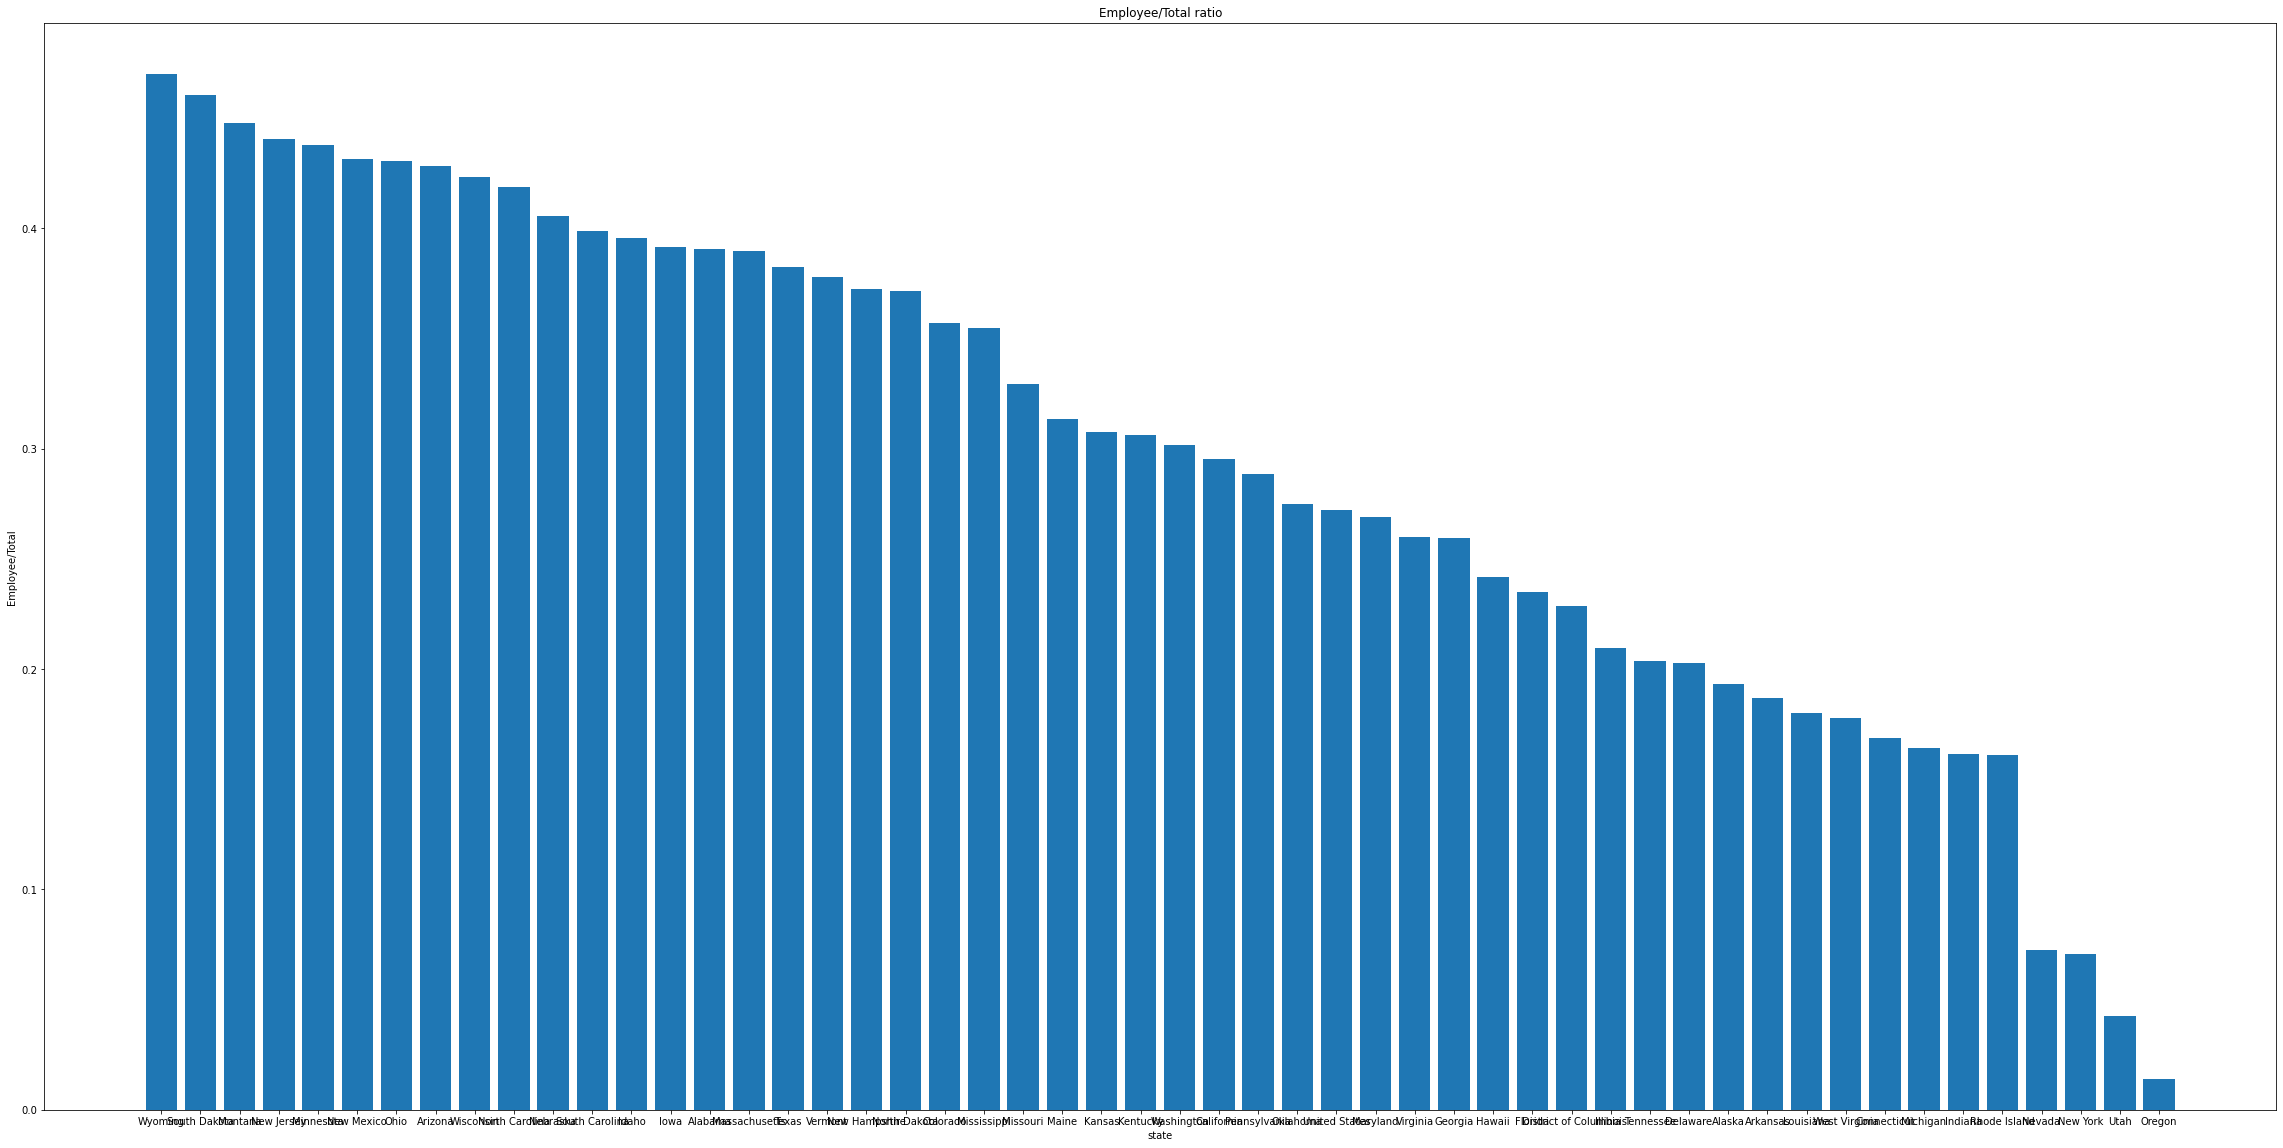

In [17]:
contribute='''SELECT geoname, amount from pension_2014 where govtypeid=1 and penitemid=11'''
x=[]
y=[]
with SQLServer('pension2014') as sqls:
    x=sqls.cur.execute(contribute).fetchall()

contribute='''SELECT geoname, amount from pension_2014 where govtypeid=1 and penitemid=1'''
with SQLServer('pension2014') as sqls:
    y=sqls.cur.execute(contribute).fetchall()

df={}
for state in range(len(x)):
    df[x[state][0]]=x[state][1]/y[state][1]
df=dict(sorted(df.items(), key=lambda item: item[1],reverse=True))

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (40, 20))
plt.bar(list(df.keys()), list(df.values()))
 
plt.xlabel("state")
plt.ylabel("Employee/Total")
plt.title("Employee/Total ratio")
plt.show()